In [1]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
import scipy.io

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
def simulate_p_strategy(ntrials, pworld, pagent):
#     world = RandomWorld([pworld], [10000])
    world = PersistentWorld(np.array([[1-pworld, pworld]]), [10000])
    # Say we pick the choice randomly with prob 0.2
    choices = []
    rewards = []
    for i in range(ntrials):
        choice = np.random.rand() < pagent
        #print('choice = ', int(choice))
        choices.append(choice)
        reward = world.update(choice)
        rewards.append(reward)
        
    efficiency = np.sum(rewards) / ntrials
    return efficiency
    
        
        

In [3]:
# Let's plot the dependence on the p-strategy
N = 20
plst = np.linspace(0, 1, N)
results = np.zeros((N, N))
for idworld, pworld in enumerate(plst):
    for idagent, pagent in enumerate(plst):
        efficiency = simulate_p_strategy(1000, pworld=pworld, pagent=pagent)
        results[idworld][idagent] = efficiency
    

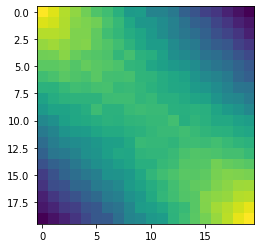

In [4]:
plt.imshow(results)

In [11]:
def simulate_agent(type, tau=0, gamma=0.1, eps=0, prew=0.8, pswitch=0.05):
    nblocks = 200
    raw_rates = np.random.rand(nblocks)
    rates = np.vstack((1-raw_rates, raw_rates)).T
    ntrials = np.random.uniform(low=20, high=30, size=nblocks).astype('int')
    
#     world = RandomWorld(rates=rates, ntrials=ntrials)
    world = PersistentWorld(rates=rates, ntrials=ntrials)
    
    if type == 'LocalMatching':
        agent = LocalMatchingAgent(tau, eps=0.1)
    elif type == 'ConstantProb':
        agent = ConstantProbAgent(0.5)
    elif type == 'PiecewiseConstantProb':
        agent = PiecewiseConstantProbAgent(rates=raw_rates, ntrials=ntrials)
    elif type == 'Matching':
        agent = MatchingAgent(eps=0.1)
    elif type == 'QLearning':
        agent = EGreedyQLearningAgent(gamma=gamma, eps=eps)
    elif type == 'Inference':
        agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=pswitch, eps=eps)

    exp = Experiment(agent, world)
    exp.run()  
    return agent.find_efficiency()


In [8]:
simulate_agent('QLearning', gamma=0.1, eps=0.1)

0.7374278647980215

In [12]:
# Simulate a clairvoyant agent for baseline performance
N = 10
results_clairvoyant = []
print('simulating clairvoyant agent...')
for iter in range(N):
    prob = simulate_agent('PiecewiseConstantProb', tau=1)
    results_clairvoyant.append(prob)
    
    
# Simulate a random agent for baseline performance
N = 10
results_random = []
print('simulating random agent...')
for iter in range(N):
    prob = simulate_agent('ConstantProb', tau=1)
    results_random.append(prob)
    
    
# Simulate a q-learning agent 
N = 10
results_qlearning = []
print('simulating q-learning agent...')
for iter in range(N):
    prob = simulate_agent('QLearning', gamma=0.01, eps=0.1)
    results_qlearning.append(prob)
    
# Simulate a inference-based agent 
N = 10
results_infbased = []
print('simulating inference-based agent...')
for iter in range(N):
    prob = simulate_agent('Inference', prew=0.8, pswitch=0.05, eps=0)
    results_infbased.append(prob)
        


simulating clairvoyant agent...
simulating random agent...
simulating q-learning agent...
simulating inference-based agent...


In [13]:
# Test the Local Matching agent with various values of tau
taulst = np.arange(1, 20, 2)
N = 10
results = np.zeros((len(taulst), N))
for idx, tau in enumerate(taulst):
    print(idx)
    for iter in range(N):
        prob = simulate_agent('LocalMatching', tau=tau)
        results[idx, iter] = prob
    

0
1
2
3
4
5
6
7
8
9


In [21]:
# Test the Q-Learning agent with various values of gamma
gammalst = np.linspace(0.01, 0.95, 10)
N = 10
qresults = np.zeros((len(gammalst), N))
for idx, gamma in enumerate(gammalst):
    print(idx)
    for iter in range(N):
        prob = simulate_agent('QLearning', gamma=gamma, eps=0.05)
        qresults[idx, iter] = prob

0
1
2
3
4
5
6
7
8
9


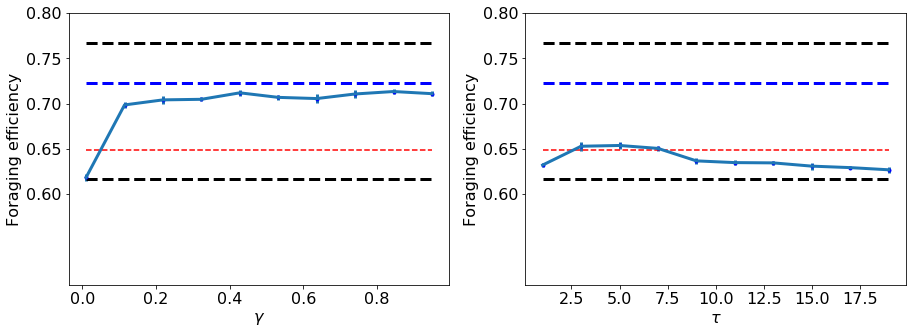

In [22]:
xlst = gammalst
ylst = qresults

# Plot the results!
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.errorbar(xlst, np.mean(ylst, axis=1), np.std(ylst, axis=1) / np.sqrt(N), linewidth=3)
plt.plot(xlst, np.mean(ylst, axis=1), 'b.')
plt.yticks([0.6, 0.65, 0.7, 0.75, 0.8], fontsize=16)
plt.ylim(0.5, 0.8)
plt.xticks(fontsize=16)
plt.ylabel('Foraging efficiency', fontsize=16)
plt.xlabel(r'$\gamma$', fontsize=16)

# Plot baseline performances
plt.hlines(np.mean(results_clairvoyant), min(xlst), max(xlst), linestyles='--', colors='k', linewidth=3)
plt.hlines(np.mean(results_random), min(xlst), max(xlst), linestyles='--', colors='k', linewidth=3)
plt.hlines(np.mean(results_infbased), min(xlst), max(xlst), linestyles='--', colors='b', linewidth=3)

plt.hlines(np.mean(results_qlearning), min(xlst), max(xlst), linestyles='--', colors='r')


xlst = taulst
ylst = results

# Plot the results!
plt.subplot(122)
plt.errorbar(xlst, np.mean(ylst, axis=1), np.std(ylst, axis=1) / np.sqrt(N), linewidth=3)
plt.plot(xlst, np.mean(ylst, axis=1), 'b.')
plt.yticks([0.6, 0.65, 0.7, 0.75, 0.8], fontsize=16)
plt.ylim(0.5, 0.8)
plt.xticks(fontsize=16)
plt.ylabel('Foraging efficiency', fontsize=16)
plt.xlabel(r'$\tau$', fontsize=16)

# Plot baseline performances
plt.hlines(np.mean(results_clairvoyant), min(xlst), max(xlst), linestyles='--', colors='k', linewidth=3)
plt.hlines(np.mean(results_random), min(xlst), max(xlst), linestyles='--', colors='k', linewidth=3)
plt.hlines(np.mean(results_infbased), min(xlst), max(xlst), linestyles='--', colors='b', linewidth=3)

plt.hlines(np.mean(results_qlearning), min(xlst), max(xlst), linestyles='--', colors='r')

## Simulating the dynamics of block switching

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [82]:
def simulate_offsets(tau, nblocks, eps, blocksize):
    raw_rates = np.array([1, 0] * nblocks)
    rates = np.vstack((1-raw_rates, raw_rates)).T
    ntrials = np.random.uniform(low=blocksize, high=blocksize, size=nblocks*2).astype('int')

    world = PersistentWorld(rates=rates, ntrials=ntrials)
    agent = LocalMatchingAgent(tau, eps=0.1)

    exp = Experiment(agent, world)
    choices, rewards = exp.run()  

    offsets = []
    for i in range(2*nblocks - 2):
        lowerlim = int((i+1) * blocksize + blocksize/2)
        upperlim = int((i+2) * blocksize + blocksize/2)
        x = np.arange(lowerlim, upperlim)[:,np.newaxis] - (i+2) * blocksize
        y = choices[lowerlim:upperlim]
        offset = find_transition_point(x, y)
        offsets.append(offset[0,0])
    return offsets
        
    
def find_transition_point(x, y):
    model = LogisticRegression(solver='liblinear', random_state=0, max_iter=1000, C=40)
    model.fit(x,y)
    return - model.intercept_ / model.coef_

In [83]:
median_offsets = []
mean_offsets = []
std_offsets = []
taulst = np.arange(20)
for tau in taulst:
    #print(tau)
    offsets = simulate_offsets(tau=3, nblocks=10, eps=0.05, blocksize=50)
    median_offsets.append(np.median(offsets))
    mean_offsets.append(np.mean(offsets))
    std_offsets.append(np.std(offsets))

<ErrorbarContainer object of 3 artists>

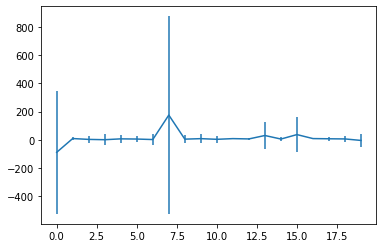

In [84]:
plt.errorbar(taulst, mean_offsets, std_offsets)

<ErrorbarContainer object of 3 artists>

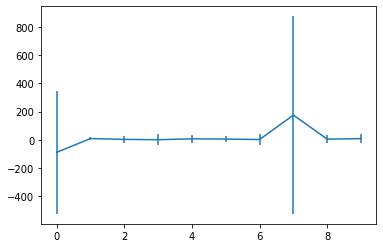

In [85]:
plt.errorbar(taulst[:10], mean_offsets[:10], std_offsets[:10])

In [88]:
tau = 3
nblocks = 10
eps = 0.05
blocksize = 50
raw_rates = np.array([1, 0] * nblocks)
rates = np.vstack((1-raw_rates, raw_rates)).T
ntrials = np.random.uniform(low=blocksize, high=blocksize, size=nblocks*2).astype('int')

world = PersistentWorld(rates=rates, ntrials=ntrials)
# agent = LocalMatchingAgent(tau, eps=0.1)
agent = QLearningAgent(gamma=0.1, type='max')

exp = Experiment(agent, world)
choices, rewards = exp.run()  

offsets = []
for i in range(2*nblocks - 2):
    lowerlim = int((i+1) * blocksize + blocksize/2)
    upperlim = int((i+2) * blocksize + blocksize/2)
    x = np.arange(lowerlim, upperlim)[:,np.newaxis] - (i+2) * blocksize
    y = choices[lowerlim:upperlim]
    offset = find_transition_point(x, y)
    offsets.append(offset[0,0])

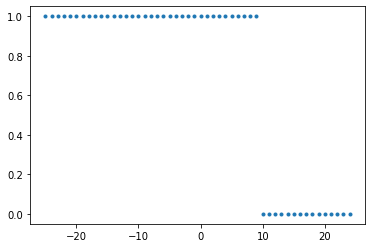

In [89]:
plt.plot(x,y,'.')

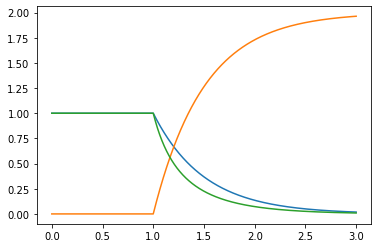

In [91]:
# Random simulation of an exponential switch
times = np.linspace(0, 3, 1000)
p1 = np.exp(-(times-1) * 2)
p1[times < 1] = 1
p2 = (1 - p1) * 2
plt.plot(times, p1)
plt.plot(times, p2)
plt.plot(times,p1 / (p1+p2))


In [92]:
world = PersistentWorld(rates=np.array([[0, 1], [1, 0], [0, 1], [1, 0]]), ntrials=[30, 30])
agent = QLearningAgent(gamma=0.1, type='max')
# agent = LocalMatchingAgent(tau=5, eps=0.1)

exp = Experiment(agent, world)
choices, rewards = exp.run()  

In [97]:
type(agent) == QLearningAgent

True

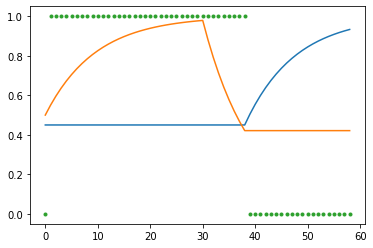

In [99]:
if type(agent) == QLearningAgent:
    q0 = np.array(agent.q0_history)
    q1 = np.array(agent.q1_history)
    plt.plot(q0)
    plt.plot(q1)
    scipy.io.savemat('qlearning-sim.mat', {'q0': q0, 'q1': q1, 'choices': choices, 'rewards': rewards})
else:  
    r0 = agent.Rewards0side_history
    r1 = agent.Rewards1side_history
    plt.plot(r0)
    plt.plot(r1)

    scipy.io.savemat('matching-sim.mat', {'r0': r0, 'r1': r1, 'choices': choices, 'rewards': rewards})
plt.plot(choices, '.')


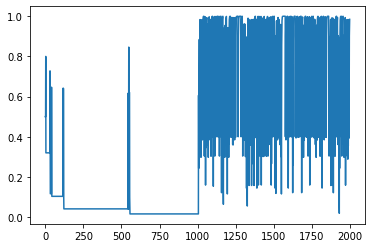

In [356]:
plt.plot(agent.q0_history)

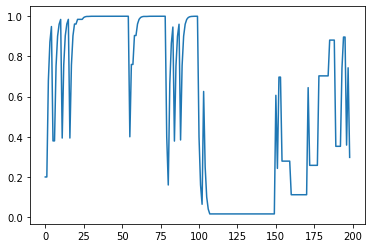

In [315]:
plt.plot(agent.q1_history)

In [316]:
agent.find_efficiency()

0.7587939698492462

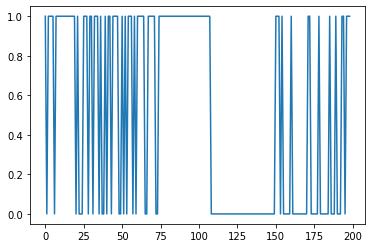

In [317]:
plt.plot(choices)

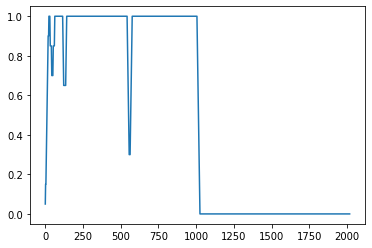

In [357]:
ave = np.convolve(choices, np.ones(20) / 20)
plt.plot(ave)

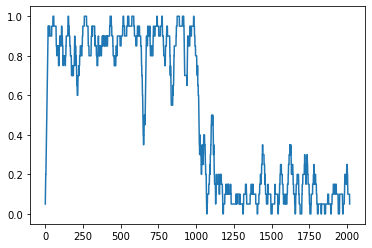

In [352]:
ave = np.convolve(choices, np.ones(20) / 20)
plt.plot(ave)